### Thermocline variability

Code timeseries of thermocline depth (depth of 0.5 degree isotherm) at inner and outer shelf locations in the Amundsen Sea

In [49]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sys
import cmocean
import os
sys.path.append('/home/users/birgal/')
from nemo_python_git.diagnostics import isosurface, thermocline
from nemo_python_git.grid import region_mask, extract_var_region
from nemo_python_git.utils import fix_lon_range

In [77]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'

In [69]:
ds1 = xr.open_mfdataset(f'{base_dir}ERA5-forcing/daily/processed/msl_y*.nc').sel(lat=slice(-50,-80)).msl.resample(time="1ME").mean()
lsm = xr.open_dataset(f'{base_dir}ERA5-forcing/climatology/land_sea_mask.nc').rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(-50,-80)).isel(time=0).lsm
lsm['lon'] = fix_lon_range(lsm['lon'])

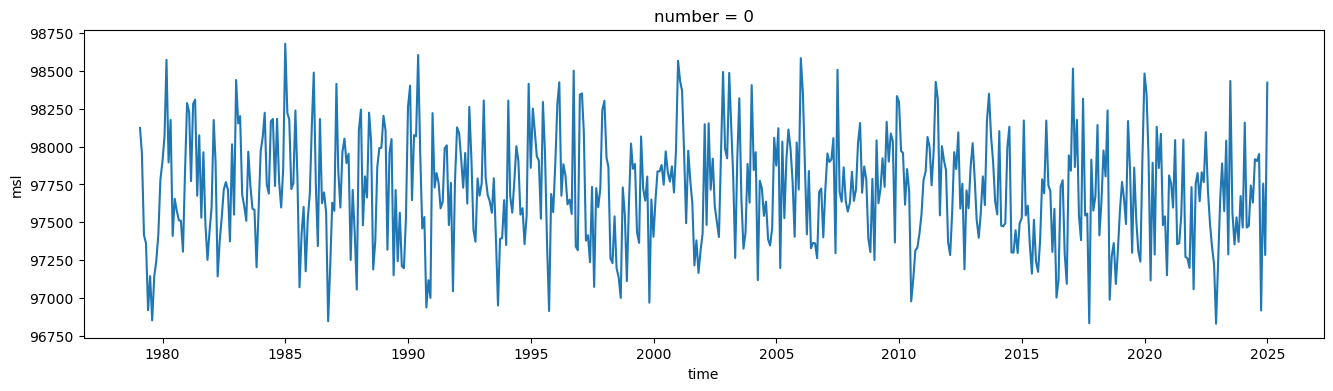

In [76]:
ds1.where(lsm==0).sel(lon=slice(-70,100)).min(dim=['lon','lat']).plot(figsize=(16,4))

In [88]:
ds_SSH = xr.open_dataset(f'{base_dir}sla_25km_1M.nc')

In [132]:
mask = (ds_SSH.longitude < 60)*(ds_SSH.longitude > 20)*(ds_SSH.latitude < -62)
# mask = (ds_SSH.longitude < 80)*(ds_SSH.longitude > -63)*(ds_SSH.latitude < -59)

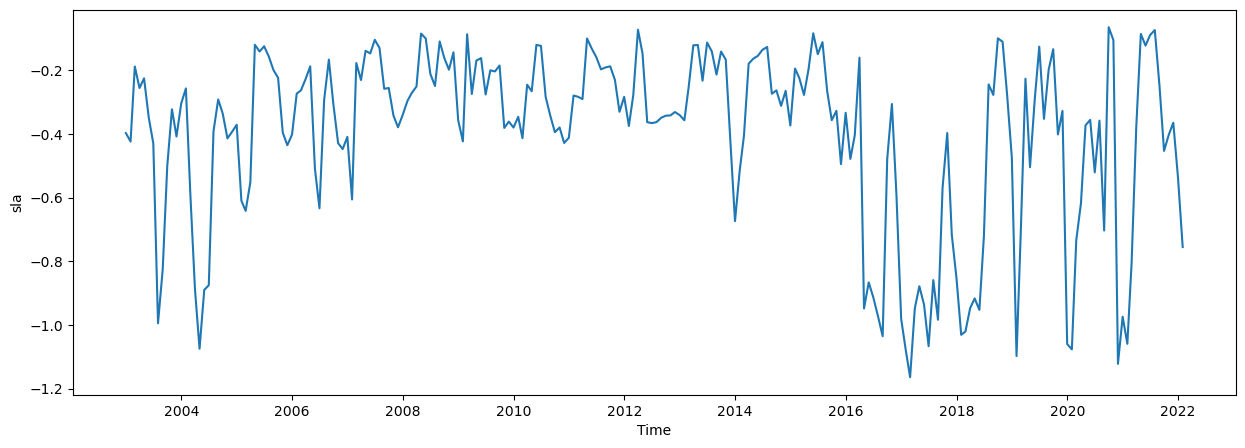

In [134]:
ds_SSH.sla.where(mask).min(dim=['u','v']).plot(figsize=(15,5))

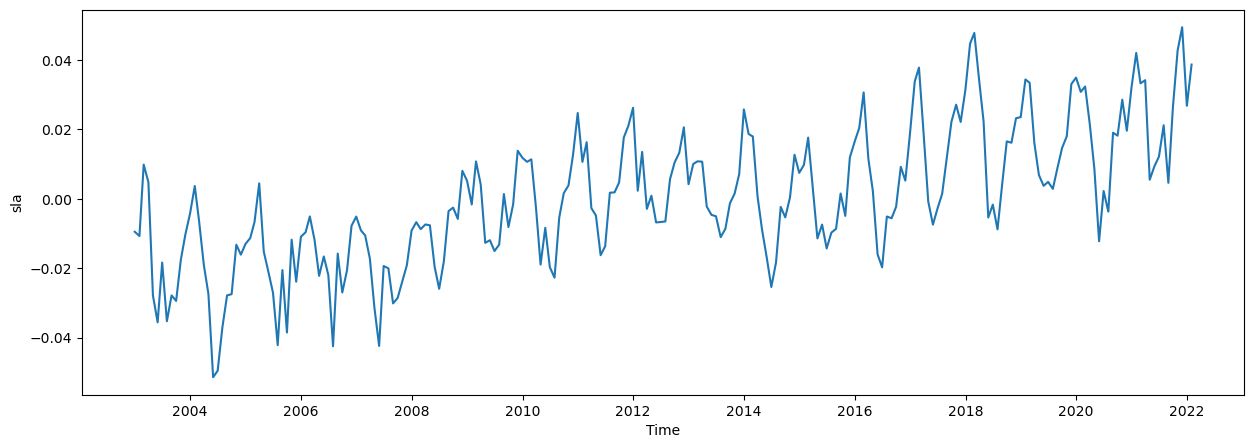

In [110]:
ds_SSH.sla.where((ds_SSH.longitude < 100)*(ds_SSH.longitude > -70)).mean(dim=['u','v']).plot(figsize=(15,5))

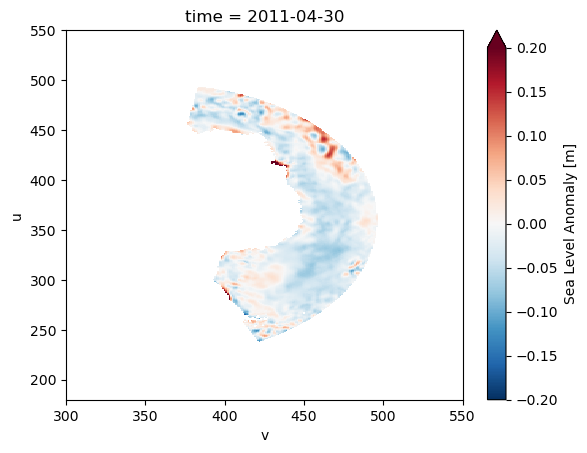

In [127]:
ds_SSH.sla.isel(time=100).where((ds_SSH.longitude < 80)*(ds_SSH.longitude > -63)*(ds_SSH.latitude < -59)).plot(xlim=(300,550),ylim=(180,550), vmin=-0.2, vmax=0.2, cmap='RdBu_r')

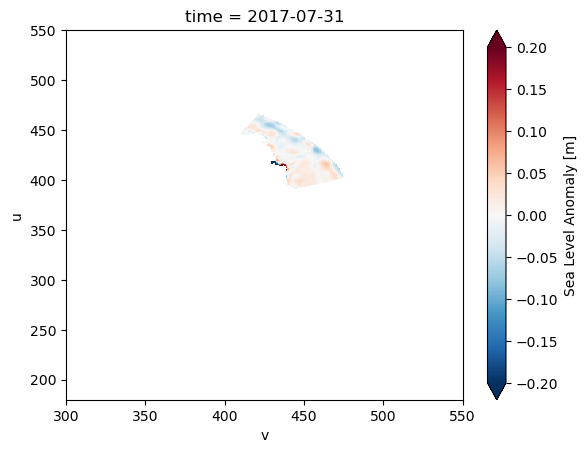

In [130]:
ds_SSH.sla.isel(time=175).where(mask).plot(xlim=(300,550),ylim=(180,550), vmin=-0.2, vmax=0.2, cmap='RdBu_r')

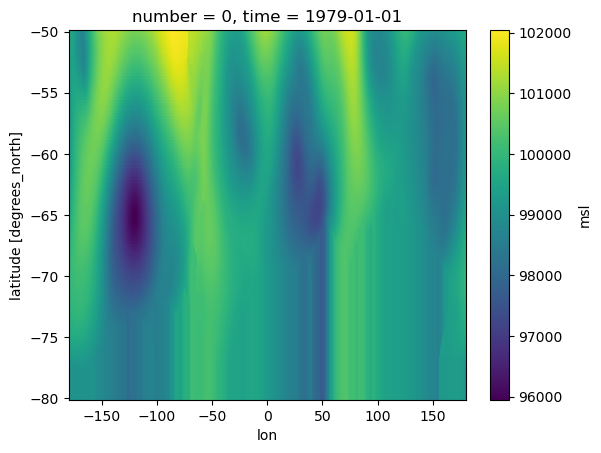

In [43]:
ds1.msl.isel(time=0).plot()

In [137]:
year=1979
ds = xr.open_dataset(f'{base_dir}output/CESM2_3hwind_1979_test1_winds/files0/eANT025.L121_1m_{year}0101_{year}1231_SBC.nc')
ds2 = xr.open_dataset(f'{base_dir}output/CESM2_3hwind_1979_test1_winds_ddf/files0/eANT025.L121_1m_{year}0101_{year}1231_SBC.nc')

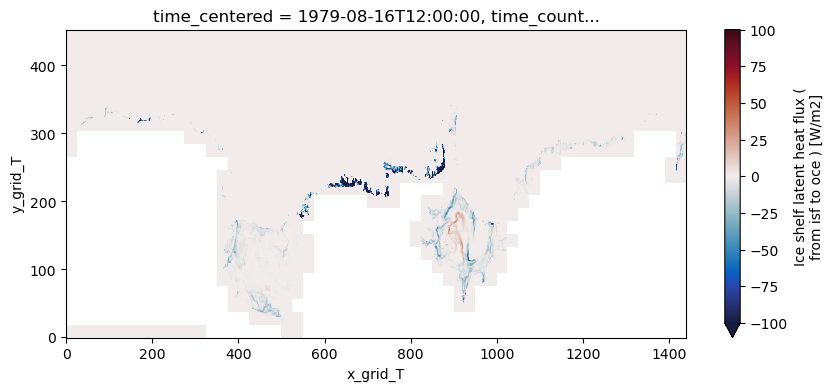

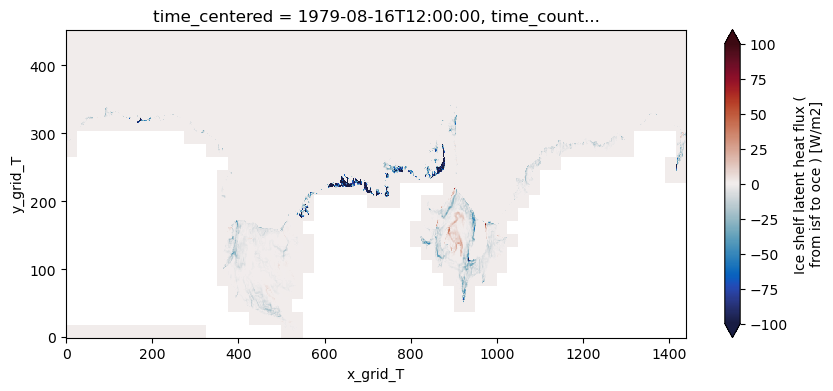

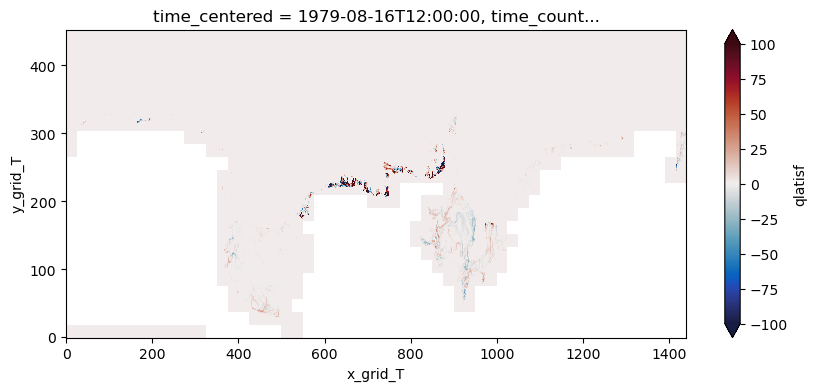

In [140]:
ds.qlatisf.isel(time_counter=7).plot(vmin=-100, vmax=100, cmap=cmocean.cm.balance, figsize=(10,4))
ds2.qlatisf.isel(time_counter=7).plot(vmin=-100, vmax=100, cmap=cmocean.cm.balance, figsize=(10,4))
(ds2.qlatisf.isel(time_counter=7) - ds.qlatisf.isel(time_counter=7)).plot(vmin=-100, vmax=100, cmap=cmocean.cm.balance, figsize=(10,4))

In [11]:
# ds        = xr.open_dataset(f'{base_dir}output/ERA5_1h_tune0_efr020/files1/eANT025.L121_1m_{year}0101_{year}1231_grid_T_compressed.nc')
year=1996
ds        = xr.open_dataset(f'{base_dir}output/CESM2_3hwind_1979_test1_winds/files0/eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc')
mesh_mask = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20250715.nc').squeeze().rename({'nav_lev':'deptht'}).drop_vars('time_counter')
domcfg    = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20250715.nc').squeeze().rename({'nav_lev':'deptht'}).drop_vars('time_counter')
T_masked  = ds.thetao.rename({'x_grid_T':'x','y_grid_T':'y'}).where(mesh_mask.tmask==1)

depth_isotherm    = isosurface(T_masked.isel(time_counter=0), 0.5, dim='deptht')
depth_thermocline = thermocline(ds.thetao.isel(time_counter=0)).rename('thermocline').to_dataset()

In [8]:
T_masked.isel(time_counter=0, deptht=0).plot(figsize=(10,4), vmin=-5, vmax=5, ylim=(180,300), xlim=(600,800), cmap=cmocean.cm.balance)

NameError: name 'T_masked' is not defined

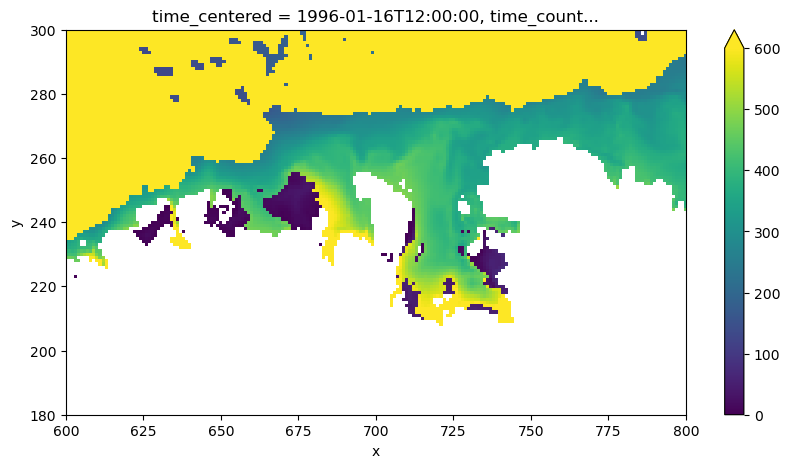

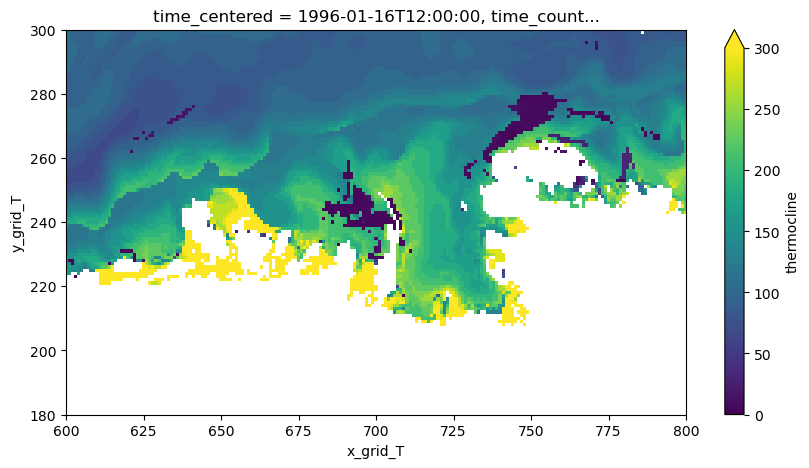

In [14]:
depth_isotherm.plot(xlim=(600,800),ylim=(180,300),vmin=0, vmax=600, figsize=(10,5))
depth_thermocline.thermocline.plot(xlim=(600,800),ylim=(180,300),vmin=0, vmax=300, figsize=(10,5))

In [5]:
# nemo_domain='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20250715.nc'
# nemo_file  = xr.open_dataset(nemo_domain)
# mask, _    = region_mask('amundsen_sea', nemo_file, option='all', return_name=False)
# mask.rename('mask_amundsen_sea_all').to_netcdf('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/regions.nc')
# mask.close()

In [5]:
mask = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/regions.nc')['mask_amundsen_sea_all']

In [6]:
# ds_thermo = thermocline(ds['thetao']).rename('depth_thermo').to_dataset()
ds_thermo = thermocline(ds['thetao'].isel(time_counter=0))

In [47]:
# mask grid locations that are land b/c argmin can't deal with it 
dTdz_masked1 = xr.where(dTdz.sum(dim='deptht')==0, 0, dTdz) #fine
# mask grid depths shallower than the first strongest negative gradient b/c that helps remove the mixed layer, but only do this outside of the cavities
z_shallowlim = xr.where(mesh_mask.rename({'x':'x_grid_T','y':'y_grid_T'}).misf!=1, 0, dTdz_masked1.argmin(dim='deptht', skipna=True)) # fine
dTdz_masked2 = dTdz_masked1.where(dTdz.deptht >= mesh_mask.rename({'x':'x_grid_T','y':'y_grid_T'}).gdept_0.isel(deptht=z_shallowlim.compute())) # fine

# find depth of first crossing of the dT/dz gradient past the defined "limit"
z_thermocline      = dTdz_masked2.where(dTdz_masked2 > 3e-3).notnull().argmax(dim='deptht', skipna=True)
depth_thermocline1 = mesh_mask.rename({'x':'x_grid_T','y':'y_grid_T'}).gdept_0.isel(deptht=z_thermocline)  # identify depth associated with this index
# only want thermoclines that are realistic
depth_thermocline2 = xr.where(z_thermocline==0, np.nan, depth_thermocline1)

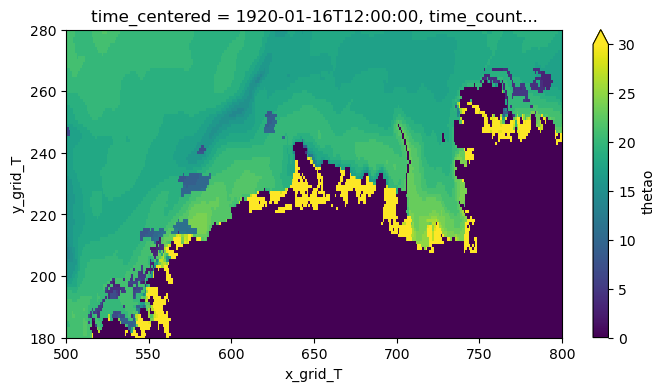

In [48]:
z_thermocline.plot(ylim=(180,280), xlim=(500,800), figsize=(8,4), vmin=0, vmax=30)#, vmin=-0.1, vmax=0.1, cmap=cmocean.cm.balance)

In [10]:
# mask grid locations that are land b/c argmin can't deal with it 
dTdz_masked  = xr.where(dTdz.sum(dim='deptht')==0, 0, dTdz)
# mask grid depths shallower than the first strongest negative gradient b/c that helps remove the mixed layer, but causes issues in ice shelfs
z_shallowlim = dTdz_masked.argmin(dim='deptht', skipna=True)
# dTdz_masked2 = dTdz_masked.where(dTdz.deptht >= ds_mesh.gdept_0.isel(deptht=z_shallowlim.compute()))

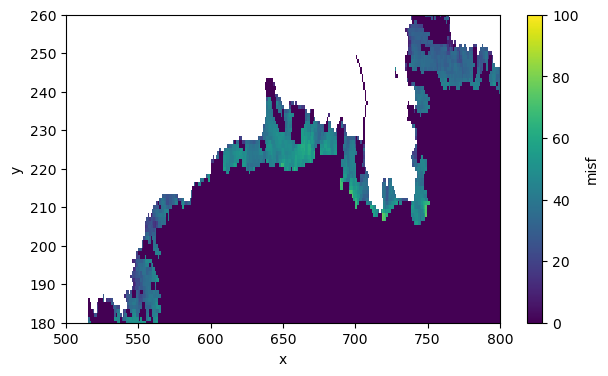

In [22]:
mesh_mask.misf.where(mesh_mask.misf!=1).plot(ylim=(180,260), xlim=(500,800), figsize=(7,4))

In [ ]:
z_shallowlim.where(mesh_mask.misf!=1).plot(ylim=(180,260), xlim=(500,800), figsize=(7,4))

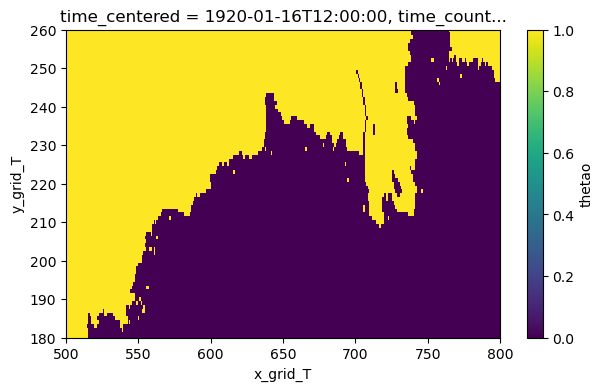

In [21]:
(dTdz_masked.where(dTdz_masked > 5e-3).sum(dim='deptht')!=0).plot(ylim=(180,260), xlim=(500,800), figsize=(7,4))

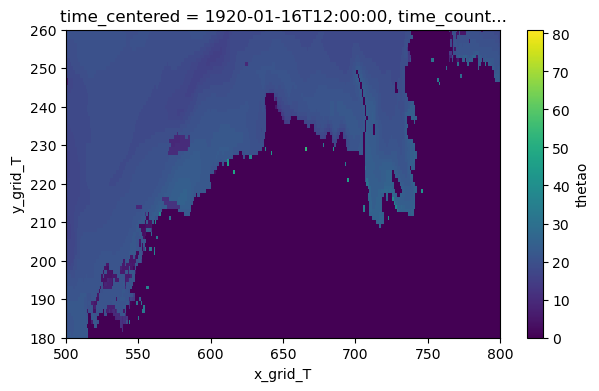

In [14]:
z_thermocline.plot(ylim=(180,260), xlim=(500,800), figsize=(7,4))

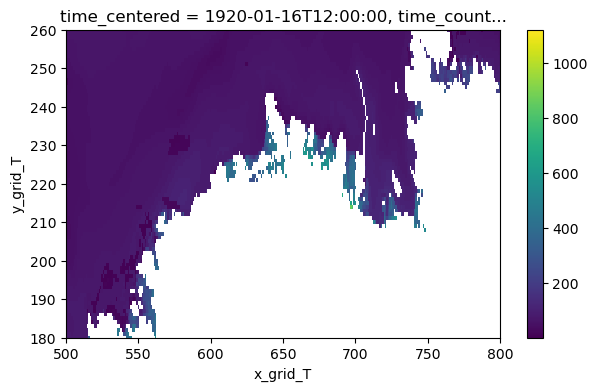

In [8]:
ds_thermo.plot(ylim=(180,260), xlim=(500,800), figsize=(7,4))

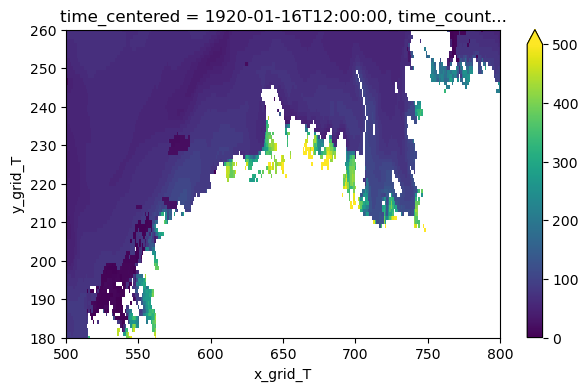

In [6]:
ds_thermo.plot(ylim=(180,260), xlim=(500,800), figsize=(7,4), vmin=0, vmax=500)

In [10]:
# find depth of first crossing of the dT/dz gradient past the defined "limit"
z_thermocline     = dTdz_masked.where(dTdz_masked > 5e-3).notnull().argmax(dim='deptht', skipna=True)

In [35]:
ds_thermo.isel(time_counter=0).mean()

#thermocline depth over full domain is identical, so just need to check how masking and area averaging is dealt with

<xarray.Dataset> Size: 24B
Dimensions:        ()
Coordinates:
    time_centered  datetime64[ns] 8B 1921-01-16T12:00:00
    time_counter   datetime64[ns] 8B 1921-01-16T12:00:00
Data variables:
    depth_thermo   float64 8B 148.2

In [24]:
def regional_mean_thermoclines(ds, regions, Tvar='thetao', region_type='all'):
    # Calculate thermocline 
    ds_thermo = thermocline(ds[Tvar]).rename('depth_thermo').to_dataset()
    
    # in case the gridT file coordinates are labelled with the grid, rename for consistency with mesh mask
    try:
        ds = ds.rename({'x_grid_T':'x','y_grid_T':'y'})
        ds_thermo = ds_thermo.rename({'x_grid_T':'x','y_grid_T':'y'})
    except:
        pass

    regional_thermoclines = xr.Dataset()
    for region in regions:
        # extract the region
        ds_region = extract_var_region(ds_thermo, 'depth_thermo', region, region_type=region_type)
        
        # weight cells in region by their area and then calculate the mean over the region
        dA = ds.area_grid_T*mask
        dA = xr.where(~np.isnan(ds_region), dA, 0)
        region_mean = (ds_region*dA).sum(dim=['x','y'])/dA.sum(dim=['x','y'])
        # (ds.area_grid_T.where(~np.isnan(ds_region.isel(time_counter=0)))).sum(dim=['x','y'])
        # region_mean = region_mean.where(region_mean!=0)
        # region_mean = ds_region.mean(dim=['x','y'])
        regional_thermoclines[f'thermocline_{region}_{region_type}'] = region_mean
    
    return regional_thermoclines, ds_region

In [25]:
thermoclines = xr.Dataset()
# regions = ['bellingshausen_sea','cosgrove','east_antarctica','filchner_ronne', \
#            'ross', 'west_antarctica', 'thwaites','dotson_crosson','getz','pine_island','pine_island_bay']
regions = ['amundsen_sea']
regional_thermos_all, thermo_region    = regional_mean_thermoclines(ds.isel(time_counter=slice(0,2)), regions, region_type='all')
# regional_thermos_shelf  = regional_mean_thermoclines(ds, regions, region_type='shelf')
# regional_thermos_cavity = regional_mean_thermoclines(ds, regions, region_type='cavity')

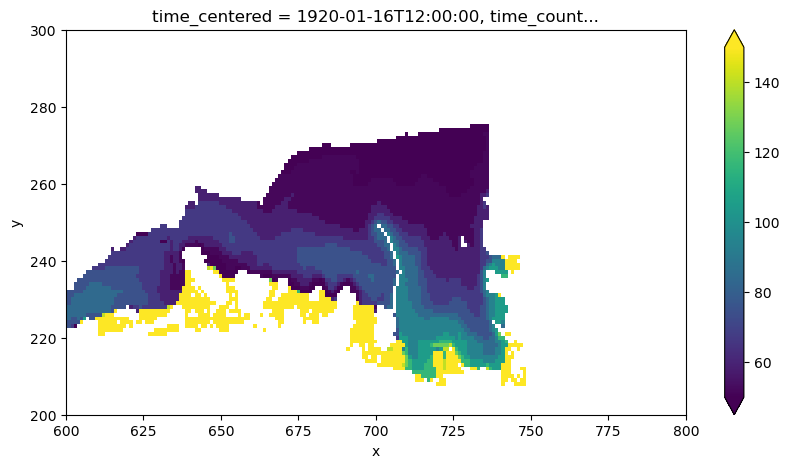

In [12]:
thermo_region.isel(time_counter=0).plot(figsize=(10,5), ylim=(200,300), xlim=(600,800), vmin=50, vmax=150)

In [26]:
print(regional_thermos_all.thermocline_amundsen_sea_all.values)

[ 98.13913472 141.16667739]


In [ ]:
#[98.13913472, 141.16667739


In [11]:
thermo_region.isel(time_counter=0).mean()

<xarray.DataArray ()> Size: 8B
array(104.99949861)
Coordinates:
    time_centered  datetime64[ns] 8B 1920-01-16T12:00:00
    time_counter   datetime64[ns] 8B 1920-01-16T12:00:00

(300.0, 0.0)

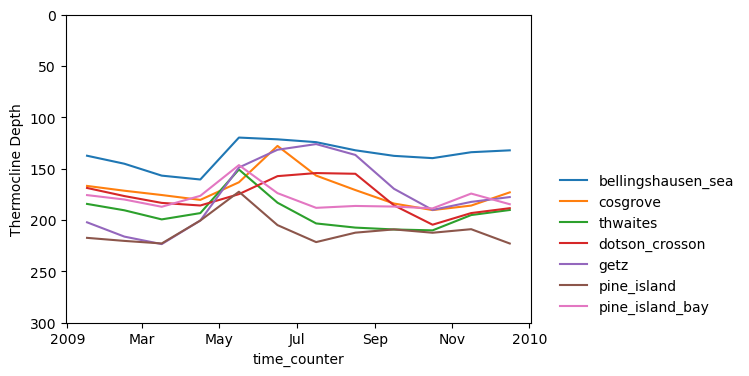

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
# for var in regional_thermos_all.data_vars:
for var in ['bellingshausen_sea','cosgrove','thwaites','dotson_crosson', 'getz','pine_island','pine_island_bay']:
    regional_thermos_all[f'thermocline_{var}_all'].plot.line(label=var,ax=ax)
ax.legend(loc=(1.05, 0.01), frameon=False)
ax.set_ylabel('Thermocline Depth')
ax.set_ylim(300, 0)

In [22]:
ds_mask = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/regions.nc')

(200.0, 260.0)

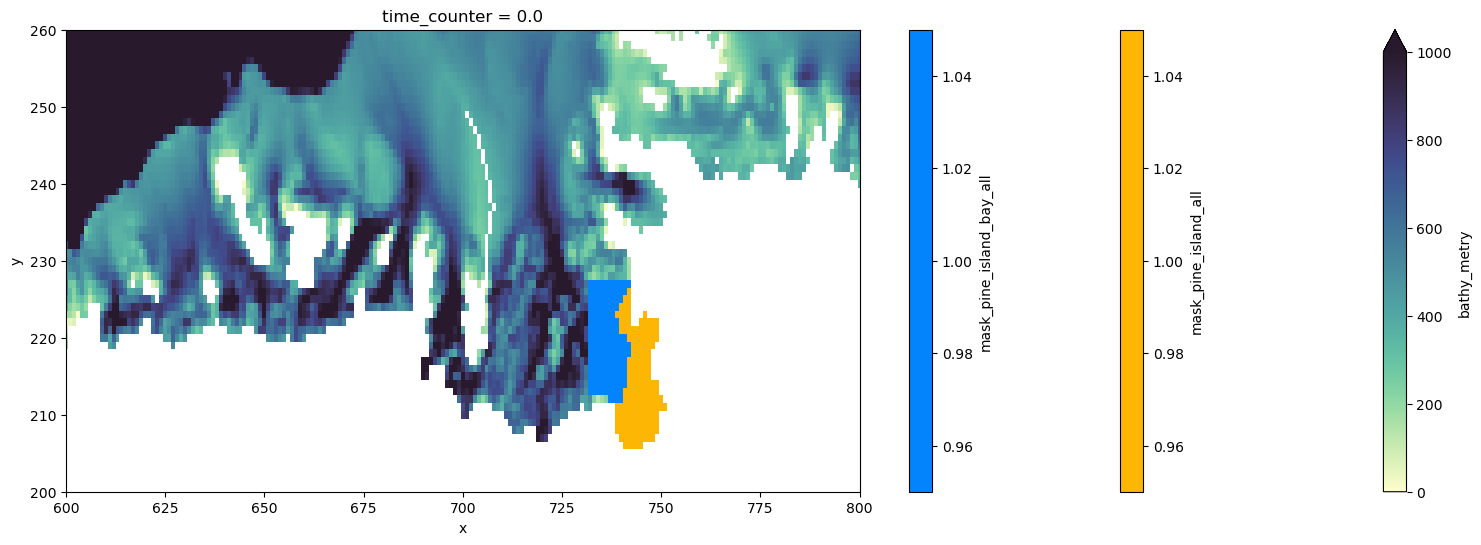

In [37]:
fig, ax = plt.subplots(1,1, figsize=(20,6))
domain_cfg.bathy_metry.where(domain_cfg.bathy_metry!=0).plot(ax=ax, vmin=0, vmax=1000, cmap=cmocean.cm.deep)
ds_mask['mask_pine_island_all'].where(ds_mask['mask_pine_island_all']).plot(cmap=ListedColormap(['#fcb603']))
ds_mask['mask_pine_island_bay_all'].where(ds_mask['mask_pine_island_bay_all']).plot(cmap=ListedColormap(['#0384fc']))

ax.set_xlim(600,800)
ax.set_ylim(200,260)

In [11]:
# too slow, consider either only calculating the thermocline once and then looping over the extracting of regions or ...
# remake regions file but with all the regions I might be interested in 

<xarray.Dataset> Size: 32B
Dimensions:        ()
Coordinates:
    time_centered  datetime64[ns] 8B 2009-01-16T12:00:00
    time_counter   datetime64[ns] 8B 2009-01-16T12:00:00
Data variables:
    amundsen_sea   float64 8B 0.0002173
    thwaites       float64 8B 0.0001712

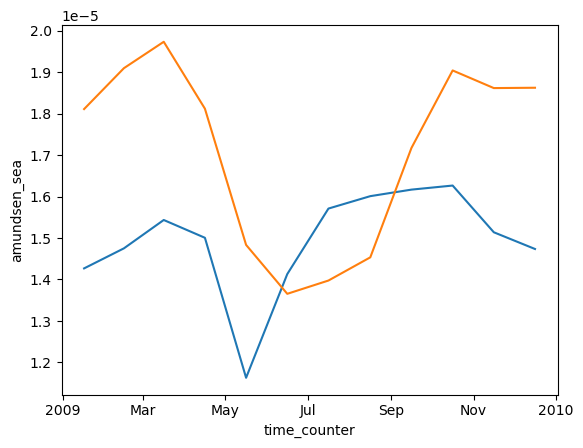

In [15]:
thermoclines['thwaites'].plot()
thermoclines['amundsen_sea'].plot()

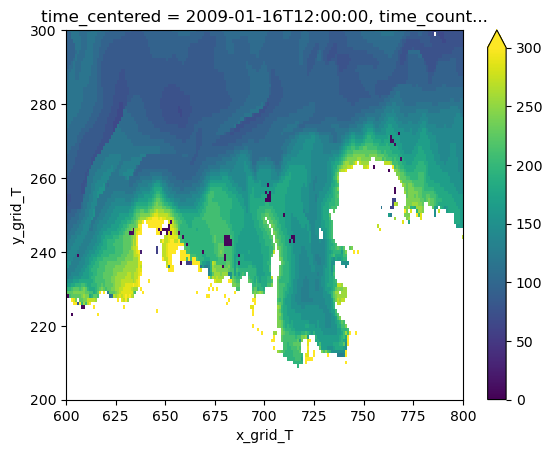

In [12]:
depth_thermocline.plot(xlim=(600,800), ylim=(200,300), vmin=0, vmax=300)

In [68]:
mesh_mask='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20250715.nc'
# load mesh mask file and mask temperature with land points
ds_mesh  = xr.open_dataset(mesh_mask).squeeze().rename({'nav_lev':'deptht'}).drop_vars('time_counter')
T_masked = ds.thetao.isel(time_counter=0).where(ds_mesh.tmask==1)

# calculate the derivative of temperature with depth
dTdz         = T_masked.differentiate('deptht')
# mask grid locations that are land b/c argmax can't deal with it and mask all depths shallower than the first depth of the strongest negative gradient
dTdz_masked1    = xr.where(dTdz.sum(dim='deptht')==0, 0, dTdz)
zind_shallowlim = dTdz_masked1.argmin(dim='deptht', skipna=True)
depth_shallow   = ds_mesh.gdept_0.isel(deptht=zind_shallowlim)
dTdz_masked2    = dTdz_masked1.where(dTdz.deptht >= depth_shallow)

# then, find the first crossing greater than limit
lim = 5e-3
dTdz_masked3     = dTdz_masked2.where((dTdz_masked2 > lim))
zind_thermocline1  = dTdz_masked3.notnull().argmax(dim='deptht',skipna=True)
depth_thermocline1 = ds_mesh.gdept_0.isel(deptht=zind_thermocline1)  # identify depth associated with this index
depth_thermocline1 = xr.where(zind_thermocline1==0, np.nan, depth_thermocline1)

# find depth of maximum dT/dz gradient, i.e. thermocline
dTdz_masked3       = xr.where(dTdz_masked3.sum(dim='deptht')==0, 0, dTdz_masked3)
zind_thermocline2  = dTdz_masked3.argmax(dim='deptht', skipna=True)               # find z index of the maximum dT/dz gradient
depth_thermocline2 = ds_mesh.gdept_0.isel(deptht=zind_thermocline2)  # identify depth associated with this index
depth_thermocline2 = xr.where(zind_thermocline2==0, np.nan, depth_thermocline2)
# # only want thermoclines that are positive; otherwise you get a few at seafloor in deep troughs in the northern southern ocean
# depth_thermocline = xr.where((dTdz_masked.max(dim='deptht') > 0), depth_thermocline, np.nan)

# offshore, the gradient method 2 works a bit better, while onshore gradient method 1 works a bit better; might just require some tuning of the limit

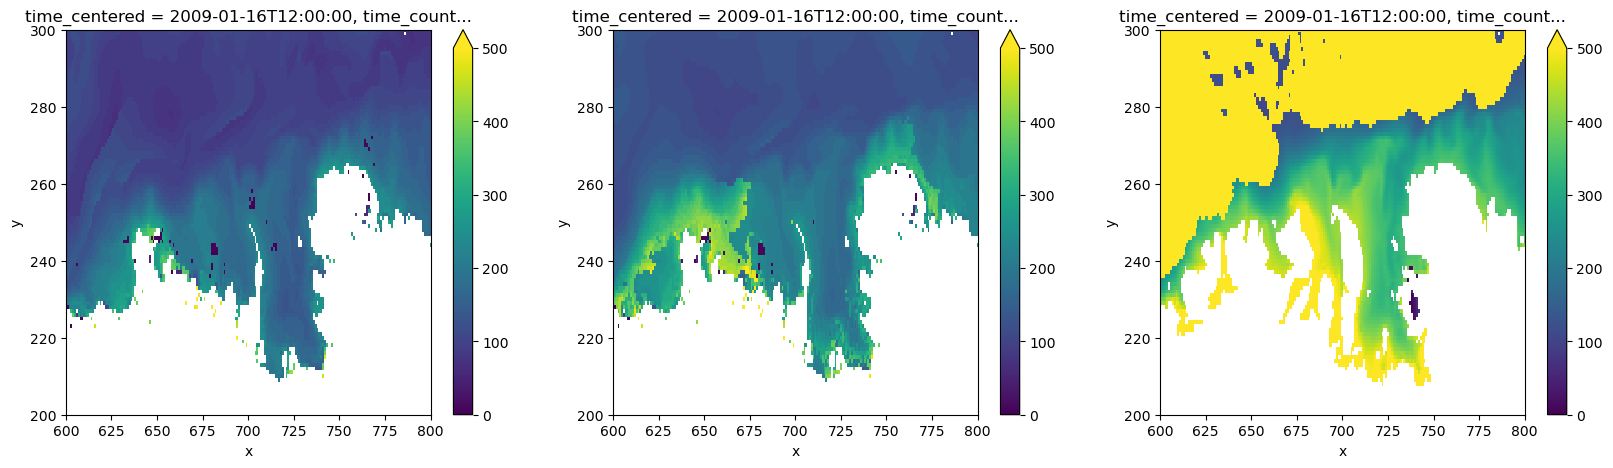

In [69]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
depth_thermocline1.plot(ylim=(200,300), xlim=(600,800), ax=ax[0], vmin=0, vmax=500)
depth_thermocline2.plot(ylim=(200,300), xlim=(600,800), ax=ax[1], vmin=0, vmax=500)
depth_isotherm.plot(ylim=(200,300), xlim=(600,800), ax=ax[2], vmin=0, vmax=500)

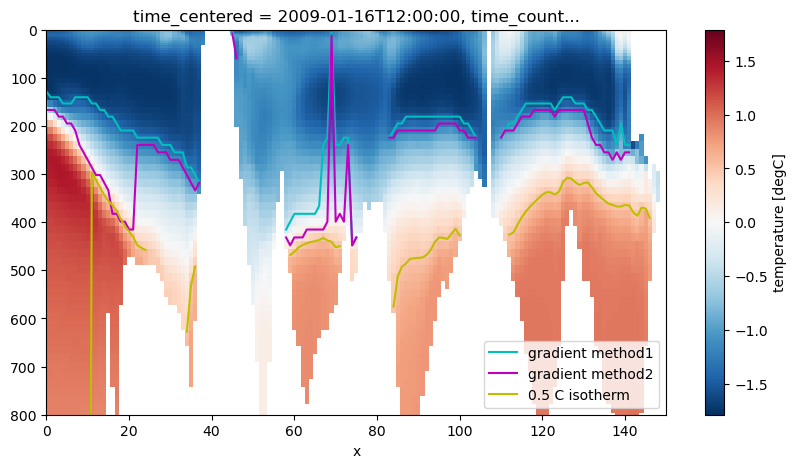

In [62]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
T_masked.isel(y=240, x=slice(600,800)).plot(ax=ax)
depth_thermocline1.isel(x=slice(600,800), y=240).plot(ax=ax, color='c', label='gradient method1')
depth_thermocline2.isel(x=slice(600,800), y=240).plot(ax=ax, color='m', label='gradient method2') 
depth_isotherm.isel(x=slice(600,800), y=240).plot(ax=ax, color='y', label='0.5 C isotherm') 
ax.set_ylim(800,0)
ax.set_xlim(0,150)
ax.legend()

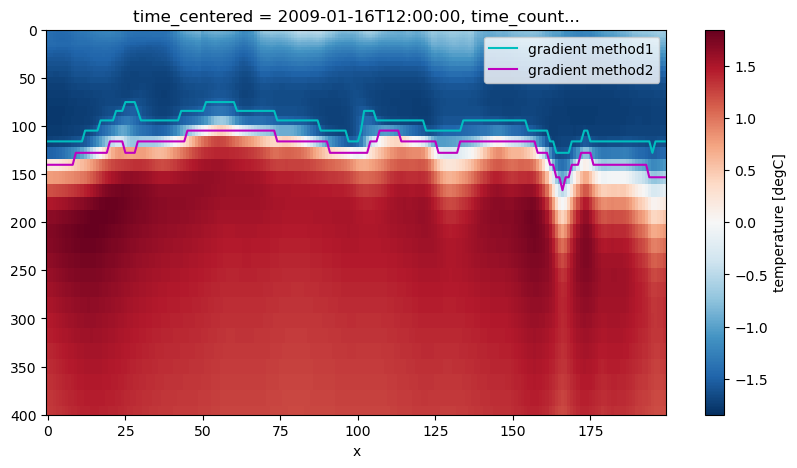

In [64]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
T_masked.isel(y=280, x=slice(600,800)).plot(ax=ax)
depth_thermocline1.isel(x=slice(600,800), y=280).plot(ax=ax, color='c', label='gradient method1')
depth_thermocline2.isel(x=slice(600,800), y=280).plot(ax=ax, color='m', label='gradient method2') 
# depth_isotherm.isel(x=slice(600,800), y=280).plot(ax=ax, color='y', label='0.5 C isotherm') 
ax.set_ylim(400,0)
ax.legend()

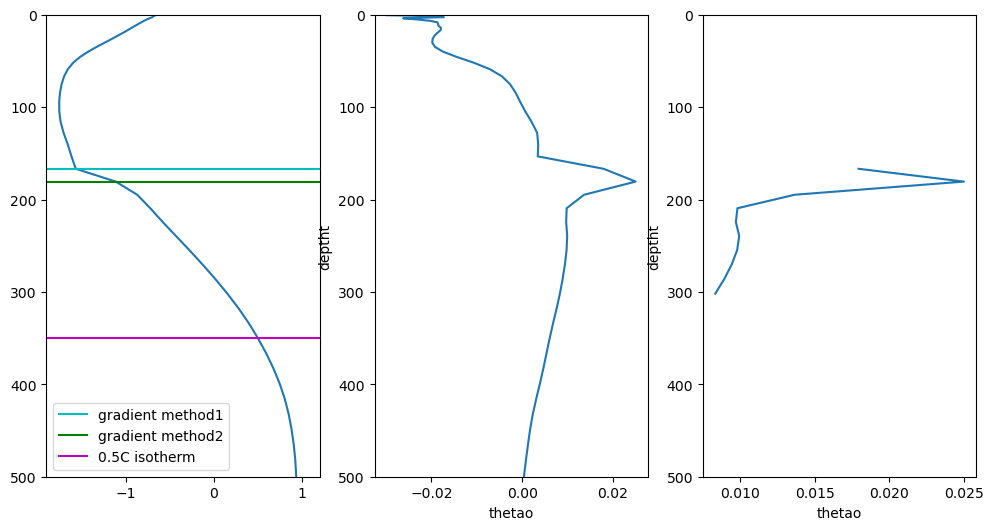

In [65]:
yloc=250
xloc=720
fig, ax = plt.subplots(1,3, figsize=(12,6))
ax[0].plot(T_masked.isel(y=yloc, x=xloc), T_masked.isel(y=yloc, x=xloc).deptht)
ax[0].axhline(depth_thermocline1.isel(x=xloc, y=yloc), color='c', label='gradient method1')
ax[0].axhline(depth_thermocline2.isel(x=xloc, y=yloc), color='g', label='gradient method2')
ax[0].axhline(depth_isotherm.isel(x=xloc, y=yloc), color='m', label='0.5C isotherm')
ax[0].legend()
ax[0].set_xlim(-1.9, 1.2)

dTdz_masked2.isel(x=xloc, y=yloc).plot(ax=ax[1], y='deptht')
dTdz_masked3.isel(x=xloc, y=yloc).plot(ax=ax[2], y='deptht')

for axis in ax.ravel():
    axis.set_ylim(500,0)
    axis.set_title('')

In [5]:
ds     = xr.open_dataset(f'{base_dir}output/ERA5_1h_tune0_efr020/files1/eANT025.L121_1m_{year}0101_{year}1231_grid_T_compressed.nc') 
# dzo    = thermocline(ds.thetao.isel(time_counter=0), surface_depth_mask=150)
# amundsen_mask = (mesh_mask.misf!=0).where((mesh_mask.x > 500)*(mesh_mask.x < 800)*(mesh_mask.y > 170)*(mesh_mask.y < 300))
dzo    = thermocline(ds.thetao.isel(time_counter=0), surface_depth_mask=0)
dzo_ds = dzo.rename({'x_grid_T':'x','y_grid_T':'y'})

In [29]:
domain_cfg = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20250715.nc')

In [17]:
# region_names
for region in ['amundsen_sea','amundsen_west_shelf_break','cosgrove','dotson_crosson', 'dotson_front', 'getz', 'pine_island', 'pine_island_bay', 'thwaites']:
    mask_region, _ = region_mask('region', domain_cfg)

In [7]:
cmap = plt.cm.get_cmap('tab10', 9)  # 'tab10' or 'Set2', etc.
colors = [cmap(i) for i in range(cmap.N)]

/tmp/ipykernel_810/323943245.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 9)  # 'tab10' or 'Set2', etc.


In [ ]:
# lon_min, lon_max, lat_min, lat_max
region_bounds = {'bear_ridge_S': [-110.35, -110.35, -74.35, -73.8791],

(190.0, 280.0)

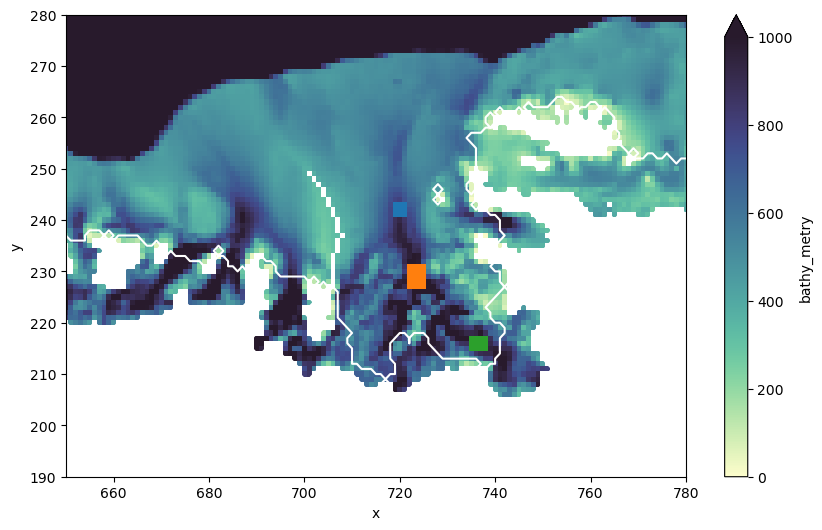

In [44]:
# regions map:
ones = xr.ones_like(domain_cfg.bathy_metry)

fig, ax = plt.subplots(1,1, figsize=(10,6))
domain_cfg.bathy_metry.where(domain_cfg.bathy_metry!=0).plot(ax=ax, vmin=0, vmax=1000, cmap=cmocean.cm.deep)

region1 = (domain_cfg.nav_lon > -107.2)*(domain_cfg.nav_lon < -106.5)*(domain_cfg.nav_lat < -73.2)*(domain_cfg.nav_lat > -73.4)
region2 = (domain_cfg.nav_lon > -106.5)*(domain_cfg.nav_lon < -105.5)*(domain_cfg.nav_lat < -74)*(domain_cfg.nav_lat > -74.3)
region3 = (domain_cfg.nav_lon > -103.3)*(domain_cfg.nav_lon < -102.3)*(domain_cfg.nav_lat < -74.8)*(domain_cfg.nav_lat > -75.0)
ones.where(region1).plot(ax=ax, cmap=ListedColormap([colors[0]]), add_colorbar=False)
ones.where(region2).plot(ax=ax, cmap=ListedColormap([colors[1]]), add_colorbar=False)
ones.where(region3).plot(ax=ax, cmap=ListedColormap([colors[2]]), add_colorbar=False)

xr.plot.contour(mesh_mask.misf, ax=ax, levels=[1], colors='w', linestyles='-')
# region_names
# for r,region in enumerate(['cosgrove', 'dotson_front', 'pine_island_bay', 'thwaites']):
#     mask_region, _ = region_mask(region, domain_cfg)
#     ones.where(mask_region==1).plot(ax=ax, cmap=ListedColormap([colors[r]]), add_colorbar=False)
#     if r > 1:
#         ax.text(600+((r-2)*40), 200, region, color=colors[r])
#     else:
#         ax.text(600+r*40, 210, region, color=colors[r])~

# ones.where(mask_dot==1).plot(ax=ax, cmap=ListedColormap(['c']), add_colorbar=False)
ax.set_xlim(650,780)
ax.set_ylim(190,280)

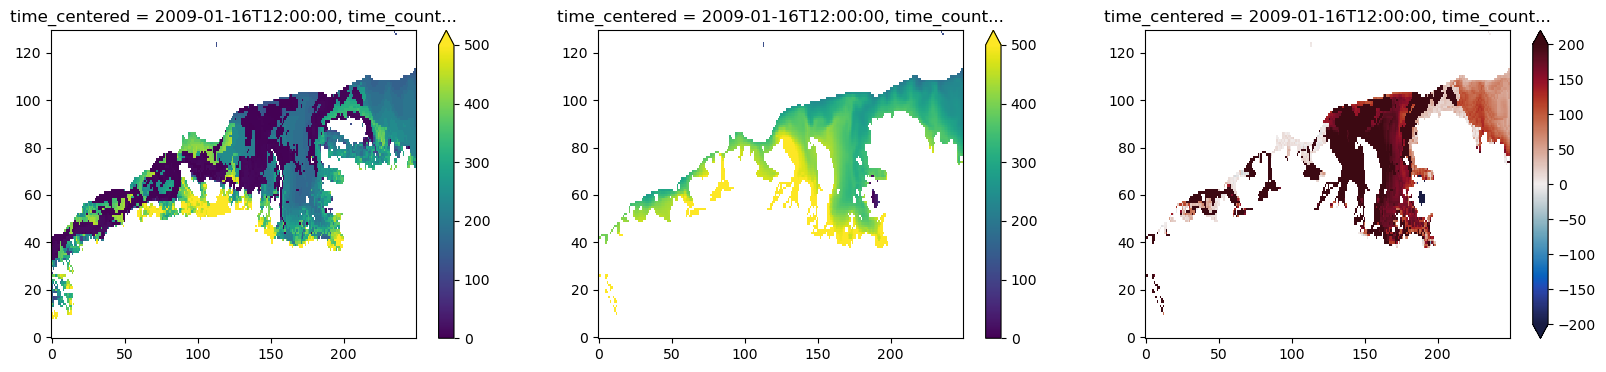

In [8]:
xslice = slice(550,800); yslice = slice(170,300);
fig, ax = plt.subplots(1,3, figsize=(20,4))
a = dzo_ds.isel(x=xslice, y=yslice).where(mesh_mask.bathy_metry.isel(x=xslice, y=yslice) < 1200)
b = depth_isotherm.isel(x=xslice, y=yslice).where(mesh_mask.bathy_metry.isel(x=xslice, y=yslice) < 1200)
c = b - a
a.plot(vmin=0, vmax=500, ax=ax[0])
b.plot(vmin=0, vmax=500, ax=ax[1])
c.plot(vmin=-200, vmax=200, ax=ax[2], cmap=cmocean.cm.balance)
for axis in ax.ravel():
    axis.set_xlabel(''); axis.set_ylabel('');

# ax[1].set_xlim(550,800)
# ax[1].set_ylim(170,300)

In [ ]:
def timeseries_thermocline (file_path, grid, mask=None, time_index=None, t_start=None, t_end=None, time_average=False):

    data = read_netcdf(file_path, 'THETA', time_index=time_index, t_start=t_start, t_end=t_end, time_average=time_average)
    if len(data.shape)==3:
        data = np.expand_dims(data,0)
    timeseries = []
    for t in range(data.shape[0]):
        # Calculate the thermocline at every point - this will mask the land
        data_tmp = thermocline(data[t,:], grid)
        # Apply mask
        if mask is not None:
            data_tmp = apply_mask(data_tmp, np.invert(mask))
        timeseries.append(area_average(data_tmp, grid))
    return np.array(timeseries)